# Some preparation

In [1]:
#@title
!pip install gpflow
!pip install sortedcontainers 
!git clone https://github.com/j-wilson/GPflowSampling.git

In [2]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection as LC
from sys import path as p

p.insert(0, '/content/GPflowSampling')

from gpflow.config import default_float
from sortedcontainers import SortedList
from gpflow_sampling.models import PathwiseGPR

In [3]:
gpflow.config.set_default_float(np.float64)
np.random.seed(7)
tf.random.set_seed(7)

# Creation of the graph

Create a grid-shaped graph of size $(\textit{num_grid}, \textit{num_grid})$

In [4]:
class Vertex:
    def __init__(self, ind: int, position: np.array, neighbors = None):
        # A vertex has a unique number, its coordinates on the plane, and a list of its neighbors 
        self.ind = ind 
        self.position = position
        self.neighbors = [] if neighbors is None else neighbors

    def __repr__(self):
        return f"({self.ind}, {[n.ind for n in self.neighbors]})"

    def __lt__(self, other):
        return self.position[0] < other.position[0]

In [5]:
def make_ver(is_edge: np.array, pos: np.array):
    ver = [Vertex(i, p) for i, p in enumerate(pos)]
    for i in range(pos.shape[0]):
        for j in range(i + 1, pos.shape[0]):
            if is_edge[i][j]:
                ver[i].neighbors.append(ver[j])
                ver[j].neighbors.append(ver[i])
    return ver

In [6]:
def make_edge(ver):
    edges = []
    for v in ver:
        for n in v.neighbors:
            edges.append(((v.ind, v.position), (n.ind, n.position)))
    return edges

In [7]:
def make_grid(num_grid, x_lim = (-2, 2), y_lim = (-1, 4)):
    x, y = np.meshgrid(
        np.linspace(*x_lim, num_grid), np.linspace(*y_lim, num_grid)
    )
    positions = np.stack([x.flatten(), y.flatten()], axis = -1)
    is_there_edge = [[False for _ in range(len(positions))] for _ in range(len(positions))]
    # Connecting vertices in directions N, E, S, W, NW, NE, SW, SE
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            if (j - i == 1 and j % num_grid != 0) or (j == i + num_grid):
                is_there_edge[i][j] = True
            elif (j == i + num_grid + 1 and i % num_grid != num_grid - 1) or (j == i + num_grid - 1 and i % num_grid != 0):
                is_there_edge[i][j] = True
    is_there_edge = np.array(is_there_edge)
    vertices = make_ver(is_there_edge, positions)
    edges = make_edge(vertices)

    return positions, vertices, edges

# A few more steps before infoBAX

We use the 2D Rosenbrock function rescaled by 10−2 as the edge cost function for the synthetic graph.

In [8]:
def Rosenbrock(x, a = 1, b = 100):
    return 0.01*((a - x[0])**2 + b*(x[1] - x[0]**2)**2) 

Useful transformations for GP, as they take values in $\mathbb{R}$, not just in $\mathbb{R}_+$.

In [9]:
def inv_soft(x):
    return np.log(np.exp(x) - 1)

def softplus(x):
    return np.log(np.exp(x) + 1)

def true_func(x):
    return inv_soft(Rosenbrock(x))

For a given path and a cost function $\textit{func}$ you may compute its cost.

In [10]:
def cost_of_path(path, func):
    value = 0
    for e in path:
        value += func(e)
    return value

Dijkstra algorithm

In [11]:
class Dijkstra:
    def __init__(self, ver):
        self.ver = ver

    def value(self, v, neigh, is_func = True):
        if is_func:
          return self.cost_func(np.sum([v.position, neigh.position], axis = 0)/2)
        else:
            ind_1, ind_2 = v.ind, neigh.ind
            return self.cost_func[(ind_1, ind_2)] if ind_1 < ind_2 else self.cost_func[(ind_2, ind_1)] 

    def run_alg(self, start, end, cost_func, is_func = True):
        self.cost_func = cost_func
        self.start = self.ver[start]
        self.end = self.ver[end]
        n = len(self.ver)
        dist = [float("inf") for _ in range(n)]
        prev = [None for _ in range(n)]
        visited = [False for _ in range(n)]
        s = SortedList()
        dist[start] = 0
        s.add((dist[start], self.start))
        while len(s) != 0:
            d, v = s.pop(0)
            visited[v.ind] = True
            for neigh in v.neighbors:
                if visited[neigh.ind] == False:
                    val = self.value(v, neigh, is_func)
                    if dist[neigh.ind] > d + val:
                        s.discard((dist[neigh.ind], neigh))
                        dist[neigh.ind] = d + val
                        prev[neigh.ind] = v.ind
                        s.add((dist[neigh.ind], neigh))
        if not is_func:
            path = []
            val = []
            d = {}
            ver_in_path = end
            while ver_in_path != start:
                v_1, v_2 = self.ver[ver_in_path], self.ver[prev[ver_in_path]]
                # Here we restrict situations with diagonally crossing edges (it will cause problems to computing inverse matrix)
                if d.get(v_1.ind + v_2.ind) is None:
                    d[v_1.ind + v_2.ind] = 1
                    value = np.sum([v_1.position, v_2.position], axis = 0)/2
                    path.append(value)
                    if v_1.ind < v_2.ind:
                        val.append(self.cost_func[(v_1.ind, v_2.ind)])
                    else:
                        val.append(self.cost_func[(v_2.ind, v_1.ind)])
                ver_in_path = prev[ver_in_path]
            return dist[end], path, val
        else:
            path = []
            ver_in_path = end
            while ver_in_path != start:
                v_1, v_2 = self.ver[ver_in_path], self.ver[prev[ver_in_path]]
                value = np.sum([v_1.position, v_2.position], axis = 0)/2
                path.append(value)
                ver_in_path = prev[ver_in_path]
            return dist[end], path


#infoBAX

Prepare initial data. 

In [12]:
# Number of requests to black-box function
budget = 120
# Initial number of objects in dataset
init = 1
# Number of samples for Monte Carlo
num_samples = 30
# Our grid: the position of each vertex; vertices (each contains its own index and position);
# edges (in the form ((v1.ind, v1.position), (v2.ind, v2.position)), contain both (v1, v2) and (v2, v1))
pos, ver, edges = make_grid(20)

# redefining edges (assuming an edge is a position between the vertices it connects)
new_edges = []
for e in edges:
    if e[0][0] < e[1][0]:
        new_edges.append(((e[0][0], e[1][0]), np.sum([e[0][1], e[1][1]], axis = 0)/2))
edge_loc = np.array([e[1] for e in new_edges])

# randomly choose first init edges
ind_of_first_edges = np.random.choice(range(len(edge_loc)), init)
first_edges = [edge_loc[i] for i in ind_of_first_edges]

# indices of edges which cost we've already have
already_known = set(ind_of_first_edges)

# hyperparameters for GP
gp_params = {
    "var": 3,
    "l": 0.3,
    "noise": 0.01
}

kernels = {
    "SE": gpflow.kernels.SquaredExponential(variance=gp_params["var"], lengthscales=gp_params["l"]),
    "Matern32": gpflow.kernels.Matern32(variance=gp_params["var"], lengthscales=gp_params["l"]),
    "Matern52": gpflow.kernels.Matern52(variance=gp_params["var"], lengthscales=gp_params["l"])
}

# Initial dataset
data = {
    "tf": (tf.constant([e for e in first_edges]), tf.constant([[true_func(e)] for e in first_edges])), 
}

# Our model (may choose another kernel)
model = PathwiseGPR(data = data["tf"], kernel = kernels["Matern52"], noise_variance=gp_params["noise"])

#Dijkstra
alg = Dijkstra(ver)

Calculate the first term (entropy) for EIG.

In [13]:
def entropy(model, X, compute_cov = True):
    num_ = X.shape[0]

    # Covariance matrix determinant
    if compute_cov is True:
        # if there's a model
        det = model.predict_f(X)[1].numpy().reshape(num_) + gp_params["noise"]
    else:
        # if entropy was called from entropy_of_post_pred_distr()
        det = [model[i][i] + gp_params["noise"] for i in range(num_)]

    for i in range(num_):
        assert det[i] > 0
    H = 1/2 + 1/2*np.log(2*np.pi) + [np.log(det[i])/2 for i in range(num_)]
    return H

Let's start counting the second term: we begin with sampling from GP.

In [14]:
# For each sample from num_samples contains the shortest path and values on the edges of this path
def sample(model, num_samples):
    paths = model.generate_paths(num_samples=num_samples, num_bases=1024)
    model.set_paths(paths)
    samples = model.predict_f_samples(tf.constant(edge_loc)).numpy().reshape((num_samples, -1))
    sub_pathes = dict([(i, _) for i in range(num_samples)])
    values = dict([(i, _) for i in range(num_samples)])

    for i in range(num_samples):
        func = dict([(new_edges[j][0], softplus(samples[i][j])) for j in range(len(new_edges))])
        dist_, path_, val_ = alg.run_alg(380, 399, func, False)
        sub_pathes[i] = np.array(path_)
        values[i] = np.array(val_)

    return sub_pathes, values

Now we calculate the entropy of $p(y_x|D_t,v_A)$.

In [15]:
def entropy_of_post_pred_distr(X_new, ker, data, subseq):
    data = (data[0].numpy(), data[1].numpy())
    arr = np.concatenate((data[0], subseq))

    k_T = ker(X_new, arr).numpy()
    k_ = k_T.T

    I = np.zeros((len(arr), len(arr)))
    for i in range(len(data[0])):
        I[i][i] = gp_params["noise"]

    K = ker(arr, arr).numpy()
    K_inv = np.linalg.inv(K + I)

    cov = ker(X_new, X_new).numpy() - k_T@K_inv@k_ + (gp_params["noise"])**2*np.eye(X_new.shape[0])

    return entropy(cov, X_new, compute_cov = False)

Putting EIG together.

In [16]:
def EIG(x, data, model, num_sam):
    first = entropy(model, X = x)
    sub_s, values = sample(model, num_sam)
    second = np.sum([entropy_of_post_pred_distr(x, model.kernel, data, sub_s[i]) for i in range(num_sam)], axis = 0)/num_sam
    return first + second

Finally, InfoBAX.

In [17]:
for t in range(budget): 
    # print(t + 1, 'epoch')
    sub_ed_first_edition = np.random.choice(range(len(edge_loc)), 100)
    sub_ed = []
    for i in sub_ed_first_edition:
        if i not in already_known:
            sub_ed.append(i)
    X = np.array([edge_loc[i] for i in sub_ed])
    # print('calculating EIG...')
    ind = np.argmax(EIG(X, data["tf"], model, num_samples)) 

    new_place_for_request = edge_loc[sub_ed[ind]]
    new_val = true_func(new_place_for_request)
    already_known.add(sub_ed[ind])
    # print('updating dataset')
    data["tf"] = (tf.concat((data["tf"][0], [new_place_for_request]), 0), tf.concat((data["tf"][1], [[new_val]]), 0))
    model = PathwiseGPR(data = data["tf"], kernel = kernels['Matern52'], noise_variance=gp_params["noise"])

Let's run Dijkstra on the true function.

In [18]:
new_dist, new_path = alg.run_alg(380, 399, Rosenbrock)

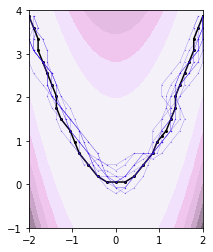

In [21]:
path_x = [a[0] for a in new_path]
path_y = [a[1] for a in new_path]
sampled_paths, val = sample(model, 11)

x = np.linspace(-2, 2, 20)
y = np.linspace(-1, 4, 20)
z = [[0 for _ in range(20)] for _ in range(20)]
for i in range(20):
    for j in range(20):
        z[i][j] = Rosenbrock(pos[i*20 + j])
h = plt.contourf(x, y, z, colors = ['#F5F1F8', '#F1E1FC', '#F0C5EE', '#E4BBE2', '#C9A5C8', '#A386A2', '#786277'])
plt.plot(path_x, path_y, '-o', color = 'black', markersize=2)
for i in range(11):
    plt.plot([e[0] for e in sampled_paths[i]], [e[1] for e in sampled_paths[i]], '-o', color = '#3F15E8', linewidth = 0.2, markersize = 0.2)

plt.axis('scaled')
plt.show()

# Animation

Before running this code, make sure all initial data for infoBAX is updated

In [19]:
grid_size = 20
x1_lims = (-2, 2)
x2_lims = (-1, 4)
positions, vertices, edges = make_grid(grid_size, x1_lims, x2_lims)
edges_ = np.array([(e[0][1], e[1][1]) for e in edges])
start, goal = vertices[-grid_size], vertices[-1]

In [20]:
def edges_of_path(path):
    edges = []
    for i in range(len(path) - 1):
        edges.append((path[i], path[i + 1]))
    return np.array(edges)

def positions_of_path(path):
    positions = [v[0][1] for v in path]
    positions.append(path[-1][1][1])
    return np.stack(positions)

In [21]:
def plot_contourf(fig, ax, x1_lims, x2_lims):
    x, y = np.meshgrid(np.linspace(*x1_lims), np.linspace(*x2_lims))
    cs = ax.contourf(x, y, Rosenbrock((x, y)), colors = ['#F5F1F8', '#F1E1FC', '#F0C5EE', '#E4BBE2', '#C9A5C8', '#A386A2', '#786277'])
    cbar = fig.colorbar(cs, ax=ax)

def plot_graph(ax, edges, start, goal):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), marker='.', facecolors='none', s=20)

    # plot start and goal vertices
    ax.scatter(*start.position, color='#FF530A', marker='s', label="Start", s=150)
    ax.scatter(*goal.position, color='#21FF65', marker='s', label="Goal", s=150)

    ax.grid(False)
    return

def plot_path(
    ax,
    path,
    path_color=(0, 0, 0, 1.),
    linewidths=2,
    linestyle="dotted",
    plot_vertices=False,
    label=None,
):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(
        path_lines,
        colors=[path_color] * len(path_lines),
        linewidths=linewidths,
        linestyle=linestyle,
        label=label,
    )
    ax.add_collection(path_lc)

    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

$\textit{file_name}$ is a file where all plots will be saved

In [22]:
for t in range(budget):
    plt.close()
    # Set model
    model = PathwiseGPR(data = data["tf"], kernel = kernels["Matern52"], noise_variance=gp_params["noise"])

    # Set and optimize acquisition function
    sub_ed_first_edition = np.random.choice(range(len(edge_loc)), 100)
    sub_ed = []
    for i in sub_ed_first_edition:
        if i not in already_known:
            sub_ed.append(i)
    X = np.array([edge_loc[i] for i in sub_ed])
    ind = np.argmax(EIG(X, data['tf'], model, num_samples))
    new_place_for_request = edge_loc[sub_ed[ind]]
    sampled_paths, val = sample(model, 11)
    sampled_paths = [sampled_paths[j] for j in range(11)]

    # print(f'Acq optimizer x_next = {new_place_for_request}')
    # print(f'Finished iter i = {t + 1}')

    fig, ax = plt.subplots(figsize=(8.9, 7)) # For square image, with colorbar

    plot_contourf(fig, ax, x1_lims, x2_lims)

    plot_graph(ax, edges_, start, goal)

    plot_path(
        ax,
        new_path,
        path_color=(0.2, 0.2, 0.2, 1),
        linewidths=2,
        linestyle='--',
        label='True shortest path',
    )

    data_ = (data['tf'][0].numpy(), data['tf'][1].numpy())

    for x in data_[0][:-1]:
            ax.scatter(x[0], x[1], color=(0, 0, 0, 1), s=40)

    ax.scatter(
        data_[0][-1][0],
        data_[0][-1][1],
        color='#3F15E8',
        s=60,
        label='Next query',
    )

    ax.set(ylim=[-1.2, 4.2], xlim=[-2.2, 2.2]) 

    weight = 0.1 # NOTE can also do: 1 / acqfn.params.n_path
    for path in sampled_paths:
        plot_path(ax, path, path_color=(0, 0, 1, weight), linewidths=2, linestyle="-")

    # Plot title
    ax.set_title("InfoBAX with Dijkstra's Algorithm")

    # Turn off ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Save plot
    fig.savefig(f'file_name/image{t + 1}.png')

    # Query function, update data
    new_val = true_func(new_place_for_request)
    already_known.add(sub_ed[ind])
    data["tf"] = (tf.concat((data["tf"][0], [new_place_for_request]), 0), tf.concat((data["tf"][1], [[new_val]]), 0))